In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filters
import sys, pylab, operator, csv
import util
import os
import urllib
%matplotlib inline

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe

[('n02483362 gibbon', 0.81378627), ('n02457408 three-toed sloth', 0.056799978), ('n02497673 Madagascar cat', 0.02585401), ('n02490219 marmoset', 0.025625255), ('n02500267 indri', 0.015745506)]


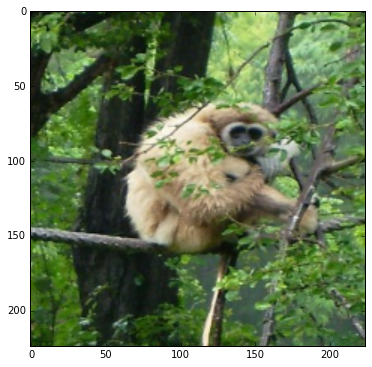

In [2]:
caffe.set_mode_cpu()
net = caffe.Net('../models/VGG16/VGG_ILSVRC_16_layers_deploy_bp.prototxt',
                '../models/VGG16/VGG_ILSVRC_16_layers_bp.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../data/ilsvrc12/synset_words.txt')
param = dict()
imgScale = 224
topBlobName = 'fc8_bp'
topLayerName = 'fc8_bp'
fwdLayerName = 'prob'
secondTopBlobName = 'fc7_bp'
secondTopLayerName = 'fc7_bp'


imgName = '/data1/imagenet-data/raw-data/validation/n02483362/ILSVRC2012_val_00028219.JPEG'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])

newSize = (imgScale,imgScale)
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)


net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', np.array([103.939, 116.779, 123.68]))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = fwdLayerName)

scores = net.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
topScores = tagScore[:5]
print(topScores)




/usr/local/lib/python2.7/dist-packages/skimage/_shared/utils.py:174: skimage_deprecation: Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be removed in a future release.
  "Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be "


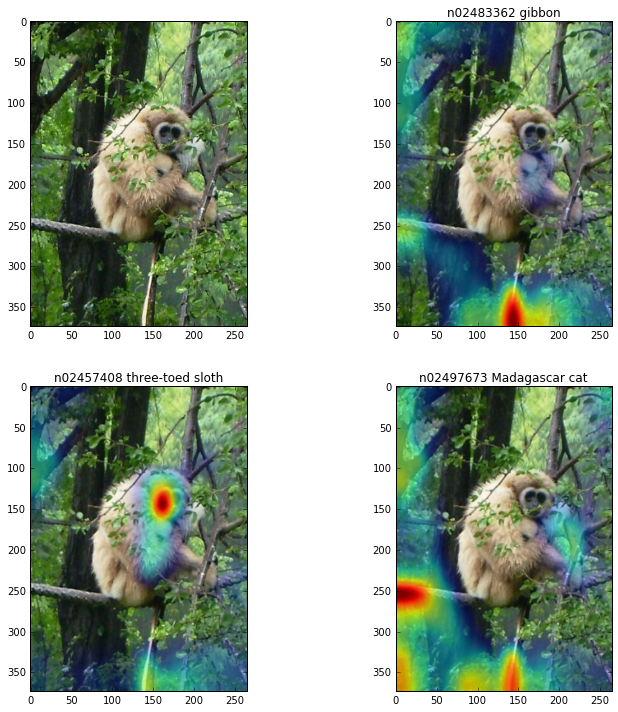

In [3]:
# switch to the excitation backprop mode
caffe.set_mode_eb_cpu() 
# specify the tags
tagName = ['n02483362 gibbon', 'n02457408 three-toed sloth', 'n02497673 Madagascar cat']
#specify the output layer name
outputLayerName = 'pool4'#'inception_5b/output'
outputBlobName = 'pool4'#'inception_5b/output'

attMaps = []

for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID].copy())
    net.blobs[topBlobName].diff[0][tagID] /= net.blobs[topBlobName].diff[0][tagID].sum()

    # invert the top layer weights
    net.params[topLayerName][0].data[...] *= -1
    out = net.backward(start = topLayerName, end = secondTopLayerName)
    buff = net.blobs[secondTopBlobName].diff.copy()

    # invert back
    net.params[topLayerName][0].data[...] *= -1 
    out = net.backward(start = topLayerName, end = secondTopLayerName)

    # compute the contrastive signal
    net.blobs[secondTopBlobName].diff[...] -= buff

    out = net.backward(start = secondTopLayerName, end = outputLayerName)
    attMap = np.maximum(net.blobs[outputBlobName].diff[0].sum(0), 0)
    attMaps.append(attMap)

util.showAttMap(img, attMaps, tagName, overlap = True, blur = False)


In [4]:
# specify the tags
caffe.set_mode_eb_cpu() 
tagName = ['n02483362 gibbon']
#specify the output layer name
topBlobName = 'fc8_bp'
topLayerName = 'fc8_bp'
fwdLayerName = 'prob'
secondTopBlobName = 'fc7_bp'
secondTopLayerName = 'fc7_bp'

outputLayerName = 'pool4'#'inception_5b/output'
outputBlobName = 'pool4'#'inception_5b/output'

attMaps = []


tagID = tag2ID['n02483362 gibbon']
net.blobs[topBlobName].diff[0][...] = 0
net.blobs[topBlobName].diff[0][tagID] = 1; # np.exp(net.blobs[topBlobName].data[0][tagID].copy())
# net.blobs[topBlobName].diff[0][tagID] /= net.blobs[topBlobName].diff[0][tagID].sum()

# invert the top layer weights
net.params[topLayerName][0].data[...] *= 1
out = net.backward(start = topLayerName, end = secondTopLayerName)
buff = net.blobs[secondTopBlobName].diff.copy()

fc8_fw_gt = net.blobs['fc7_bp'].diff[0].flatten()
print "fc7_bp_gt shape:" + str(fc8_fw_gt.shape)

# invert back
net.params[topLayerName][0].data[...] *= -1 
out = net.backward(start = topLayerName, end = secondTopLayerName)

# compute the contrastive signal
net.blobs[secondTopBlobName].diff[...] -= buff

out = net.backward(start = secondTopLayerName, end = outputLayerName)


select_bp_gt = net.blobs[topBlobName].diff[0].flatten()
print "select_bp_gt shape:" + str(select_bp_gt.shape)



print fc8_fw_gt


fc7_bp_gt shape:(4096,)
select_bp_gt shape:(1000,)
[  0.00000000e+00   0.00000000e+00   1.53499178e-03 ...,   7.63299249e-06
   0.00000000e+00   0.00000000e+00]


In [5]:
caffe.set_mode_cpu()
net = caffe.Net('../models/ccs_bp/ccs_bp.prototxt',
                '../models/VGG16/VGG_ILSVRC_16_layers_bp.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../data/ilsvrc12/synset_words.txt')
param = dict()


In [6]:
imgScale = 224
topBlobName = 'fc8_bp'
topLayerName = 'fc8_bp'
secondTopLayerName = 'pool5/7x7_s1'
secondTopBlobName = 'pool5/7x7_s1'
forwardtoLayerName = 'fc8_diff'
forwardtoBlobName = 'select_bp'

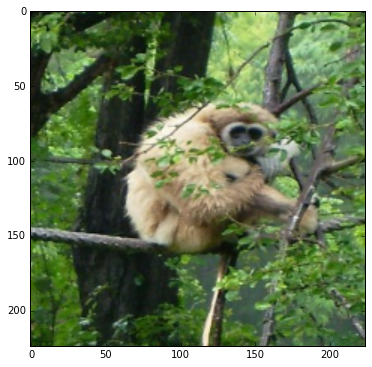

In [7]:
imgName = '/data1/imagenet-data/raw-data/validation/n02483362/ILSVRC2012_val_00028219.JPEG'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])

newSize = (imgScale,imgScale)
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)

In [8]:
net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', np.array([103.939, 116.779, 123.68]))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = forwardtoLayerName)

scores = net.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
print(tagScore[:10])

[('n02483362 gibbon', 0.81378627), ('n02457408 three-toed sloth', 0.056799978), ('n02497673 Madagascar cat', 0.02585401), ('n02490219 marmoset', 0.025625255), ('n02500267 indri', 0.015745506), ('n02510455 giant panda', 0.0078683142), ('n02493509 titi', 0.0075953254), ('n02488291 langur', 0.0072002714), ('n02493793 spider monkey', 0.0060914797), ('n01622779 great grey owl', 0.0045813913)]


In [ ]:
select_bp = net.blobs["select_bp"].data[0].flatten()
# print "shape of select_bp:" + str(select_bp.shape)
print "checking select bp:" + str(np.array_equal(select_bp,select_bp_gt))

fc8_fw = net.blobs["fc8_diff"].data[0].flatten()
print "shape of fc8_diff:" + str(fc8_fw.shape)
print "checking fc8_diff:" + str(np.array_equal(fc8_fw,fc8_fw_gt))
print fc8_fw